In [1]:
import os
import shutil
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import math
import numpy as np
import scipy.signal as signal
import scipy.fft as fft
import pickle

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

import allensdk
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

# Confirming your allensdk version
print(f"Your allensdk version is: {allensdk.__version__}")

Your allensdk version is: 2.15.2


In [ ]:
#we import the LFP functions
import importlib
import LFP_functions
importlib.reload(LFP_functions)

# LFP data obtention from Allen Dataset

In [ ]:
# Update this to a valid directory in your filesystem. This is where the data will be stored.
output_dir = r'E:/BT_Code'
DOWNLOAD_COMPLETE_DATASET = False
manifest_path = os.path.join(output_dir, "manifest.json")
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

Check the manifest downloaded. We worked with version 0.5.0

In [ ]:
print(cache.current_manifest())
cache.load_latest_manifest()

We now select the probes in VISp from session data in the dataset that suit our specifications and store them in lfp_VISp. This array contains the probe and session IDs, which we will use to download the LFP

In [ ]:
ecephys_sessions = cache.get_ecephys_session_table()
probes = cache.get_probe_table()
valid_lfp = probes[probes['has_lfp_data']] #we select sessions with LFP data

#we find the indices for our sessions of interest (wt mice, 3uL reward, images G and containing a probe in VISp)
wt_indices = ecephys_sessions[ecephys_sessions['genotype'] == 'wt/wt'][ecephys_sessions['session_type'] == 'EPHYS_1_images_G_3uL_reward'].index.tolist()
lfp_VISp = valid_lfp[(valid_lfp['structure_acronyms'].str.contains(", 'VISp',")) & (valid_lfp['ecephys_session_id'].isin(wt_indices))]
lfp_VISp

For our work, we used 16 sessions. The probe and session ids are all stored in probe_ids and session_ids respectively

In [ ]:
probe_ids = [1055324729, 1062886498, 1055328906, 1065764271, 1067688317, 1081293774, 1081297300, 1104418694, 1108676394, 1109998730, 1117240990, 1118711338, 1120380894, 1128939997, 1130463465, 1140256852]

session_ids = []
for probe_id in probe_ids:
    session_id = probes.loc[probe_id]['ecephys_session_id']
    if session_id not in session_ids:
        session_ids.append(session_id)

We now obtain the LFPs and save them as pickle files. ATTENTION: each LFP file weights several GBs, so this is will take a long time. Make sure you work with a GPU or an overall powerful computer to avoid memory errors during the code execution.

In [ ]:
sessions = {} #dictionary of sessions
for ses in range(len(probe_ids)):
    sessions[ses+1] = cache.get_ecephys_session(
                ecephys_session_id=session_ids[ses])
    #here we are getting the LFP data for the probe
    lfp = sessions[ses+1].get_lfp(probe_ids[ses])
    #we save the LFP data as a pickle file

    pickle_file_path = "lfp_data/lfp_data_"+str(ses+1)+".pickle"
    with open(pickle_file_path, "wb") as file:
        pickle.dump(lfp, file)

# LFP alingment to stimuli and V1 selection

We are first going to select the stimulus presentation data for the active task and the passive replay. The LFP data is then aligned to the presentation of novel images with the align_image_lfps function. Finally, we select the channels in V1.

In [6]:
# Check if the folders to store the aligned LFPs and channels exist, if not, create it
if not os.path.exists("aligned_LFP_area"):
    os.makedirs("aligned_LFP_area")

if not os.path.exists("channels"):
    os.makedirs("channels")


#save in stim_active the stim_presentations with the stimulus_block 0
for ses in range(len(session_ids)):
    probe_id = probe_ids[ses] #select the probe id for the session
    stim_presentations = sessions[ses+1].stimulus_presentations
    stim_active = stim_presentations[stim_presentations['stimulus_block'] == 0]
    stim_passive = stim_presentations[stim_presentations['stimulus_block'] == 5]

    #we obtain alligned LFP data given the active session
    aligned_lfps_act = LFP_functions.align_image_lfps(stim_active,lfp)

    #we obtain alligned LFP data given the passive session
    aligned_lfps_pas = LFP_functions.align_image_lfps(stim_passive,lfp)

    #we select the channels within V1
    chans = sessions[ses+1].get_channels()
    aligned_lfps_act_en_V1,chans_V1 = LFP_functions.select_area(aligned_lfps_act, chans, probe_id, 'VISp')
    aligned_lfps_pas_en_V1,_ = LFP_functions.select_area(aligned_lfps_pas, chans, probe_id, 'VISp')

    #save aligned_lfps_V1 and chans_V1 in a pickle file for each session
    with open("aligned_LFP_area/aligned_lfps_act_V1"+str(ses)+".pickle", "wb") as file:
        pickle.dump(aligned_lfps_act_en_V1, file)
    with open("aligned_LFP_area/aligned_lfps_pas_V1_"+str(ses)+".pickle", "wb") as file:
        pickle.dump(aligned_lfps_pas_en_V1, file)
    with open("channels/chans_V1_"+str(ses)+".pickle", "wb") as file:
        pickle.dump(chans_V1, file)


Once we have the aligned lfp data for each session and the channels, we can compute the power spectra and Current Source Density (see notebooks get_power_spectra and get_CSD)

# Extra code: visualize number of presentations and probe locations

In [7]:
# Specify the file path of the pickle file
ses=1
pickle_file_path = "aligned_LFP_area/aligned_lfps_act_V1_"+str(ses)+".pickle"

# Load the LFP data from the pickle file
with open(pickle_file_path, "rb") as file:
    lfp= pickle.load(file)

We obtain the active and passive stimuli for separate. Although they both have the same 'stimulus_name' atribute, they have different 'stimulus_block' values, where the active task corresponds to block 0 and the passive to block 5. We use this to obtain the two dataframes.

In [24]:
stim_presentations = session.stimulus_presentations
stim_presentations[['stimulus_block','stimulus_name']][stim_presentations['stimulus_name'] != stim_presentations['stimulus_name'].shift(1)]

stimulus_block  \
stimulus_presentations_id                   
0                                       0   
4804                                    1   
4805                                    2   
8450                                    3   
8451                                    4   
8601                                    5   

                                                         stimulus_name  
stimulus_presentations_id                                               
0                          Natural_Images_Lum_Matched_set_ophys_G_2019  
4804                                                       spontaneous  
4805                                                gabor_20_deg_250ms  
8450                                                       spontaneous  
8451                                                       flash_250ms  
8601                       Natural_Images_Lum_Matched_set_ophys_G_2019

In [25]:
#save in stim_active the stim_presentations with the stimulus_block 0
stim_active = stim_presentations[stim_presentations['stimulus_block'] == 0]
stim_passive = stim_presentations[stim_presentations['stimulus_block'] == 5]

print('number of active trials:', len(stim_active))
print('number of passive trials:', len(stim_passive))


number of active trials: 4804
number of passive trials: 4804


As we can see, the stimuli have the same length. In fact, as stated in Allen Visual Behavior Technical Whitepaper, it is a fram-for-frame replay of active behavior, the only difference is that the lick spout was retracted and therefore the mouse was unable to earn rewards.

number of pickle files: 9


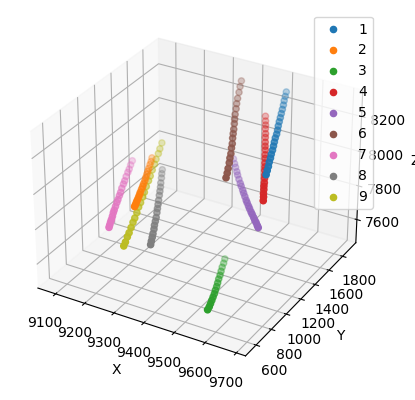

In [17]:
#import all pickle files in the folder channels

pickle_files = sorted([f for f in os.listdir('channels') if f.endswith('.pickle')])
print('number of pickle files:', len(pickle_files))

#open the pickle files and save them in a dicitonary
channels = {}

for i,file in enumerate(pickle_files):
    with open('channels/'+file, "rb") as file:
        channel = pickle.load(file)
        channels[i+1] = channel

#plot the ccf positions of every channel in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for channel in channels:
    ax.scatter(channels[channel]['anterior_posterior_ccf_coordinate'], channels[channel]['dorsal_ventral_ccf_coordinate'], channels[channel]['left_right_ccf_coordinate'])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#add a legend
ax.legend(channels.keys())
        

In [46]:
#we check that the dimensions of the act and pas dictionaries are the same
print('top: act stimuli\nbottom: pas stimuli')
print('------------------------')
for key in sorted(aligned_lfps_act_en.keys()):
    val = aligned_lfps_act_en[key]
    print(key,val.shape)
    print(key,aligned_lfps_pas_en[key].shape)
    print('------------------------')

top: act stimuli
bottom: pas stimuli
------------------------
im012_r (96, 22, 23250)
im012_r (96, 22, 23250)
------------------------
im036_r (96, 23, 24375)
im036_r (96, 23, 24375)
------------------------
im044_r (96, 23, 16500)
im044_r (96, 23, 16500)
------------------------
im047_r (96, 23, 24375)
im047_r (96, 23, 24375)
------------------------
im078_r (96, 21, 25125)
im078_r (96, 21, 25125)
------------------------
im083_r (96, 22, 22875)
im083_r (96, 22, 22875)
------------------------
im111_r (96, 21, 14250)
im111_r (96, 21, 14250)
------------------------
im115_r (96, 21, 18000)
im115_r (96, 21, 18000)
------------------------


As we can see, the two dictionaries the exact same number of elements (that is, presentation ids and maximum timesteps for every image)